## **Introduction**

DeepFER: Facial Emotion Recognition Using Deep Learning is a project aimed at developing a robust and efficient system for automatically identifying human emotions from facial expressions. By leveraging advanced deep learning techniques, particularly Convolutional Neural Networks (CNNs) and Transfer Learning, DeepFER is designed to classify emotions such as happiness, sadness, anger, surprise, fear, disgust, and neutrality from facial images.

Facial emotion recognition plays a crucial role in numerous applications, including human-computer interaction, customer service, and mental health monitoring. Traditional approaches relied on handcrafted features and rule-based systems, which often struggled to generalize across diverse faces and real-world conditions. DeepFER addresses these challenges by using deep neural networks to automatically learn hierarchical features from raw image data, achieving high accuracy and real-time performance.

The ultimate goal of DeepFER is to create a versatile and practical tool that allows machines to understand and respond to human emotions, bridging the gap between artificial intelligence and empathetic human-machine interactions.

---

## **Dataset Overview**

DeepFER utilizes the **FER-2013 dataset**, a widely used benchmark for facial emotion recognition. Key characteristics of the dataset are:

* **Image Format:** 48x48 pixel grayscale images
* **Data Alignment:** Faces are automatically registered to be centered and occupy a similar area within the image
* **Dataset Size:**

  * Total: 24,400 images
  * Training set: 22,968 images
  * Public test set: 1,432 images
* **Emotion Classes:**

  1. Angry
  2. Disgust
  3. Fear
  4. Happy
  5. Sad
  6. Surprise
  7. Neutral
* **Data Characteristics:**

  * Grayscale images to simplify computational requirements
  * Poses are consistent to focus on facial expressions
  * Captures both posed and spontaneous expressions for better generalization

The FER-2013 dataset provides a solid foundation for training and evaluating the DeepFER model, allowing for accurate and real-time classification of seven distinct human emotions.




## **Installing Required Libraries**

In [3]:
# Upgrade pip (optional but recommended)
!pip install --upgrade pip

# Install required libraries
!pip install tensorflow keras opencv-python-headless numpy pandas scikit-learn matplotlib seaborn


## **Verify Installations**

In [2]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Seaborn version:", sns.__version__)

TensorFlow version: 2.19.0
OpenCV version: 4.12.0
NumPy version: 2.0.2
Pandas version: 2.2.2
Seaborn version: 0.13.2


In [4]:
import numpy as np             # Numerical operations
import pandas as pd            # Data manipulation / CSV I/O
import os                      # File system operations
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns          # Enhanced visualization
import tensorflow as tf        # Deep learning framework
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
import cv2                     # Image processing
from tensorflow.keras.applications import VGG16, InceptionResNetV2  # For transfer learning
from keras import regularizers                                     # Optional: add weight regularization
from keras.preprocessing import image                               # Alternative to tf.keras.preprocessing
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## **Data Ingestion**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_dir = "/content/drive/MyDrive/DeepFER_dataset/train"
test_dir = "/content/drive/MyDrive/DeepFER_dataset/validation"

## **Displaying one image for each emotion in train set**

In [7]:
import os
class_names = os.listdir("/content/drive/MyDrive/DeepFER_dataset/train")
print(class_names)

['sad', 'surprise', 'neutral', 'happy', 'fear', 'disgust', 'angry']


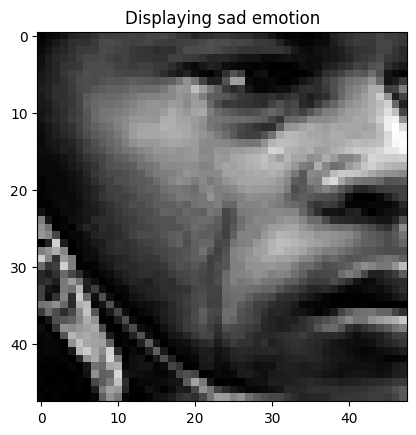

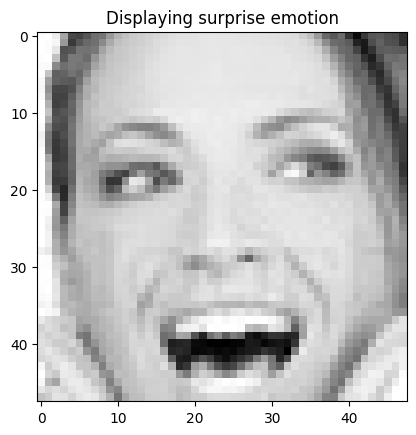

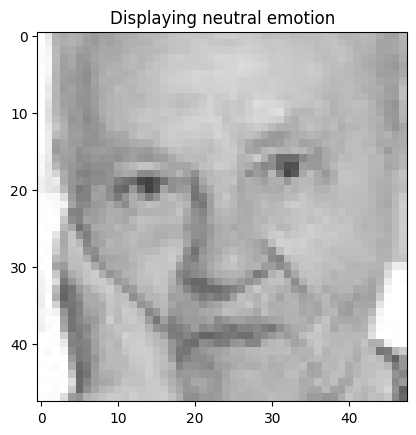

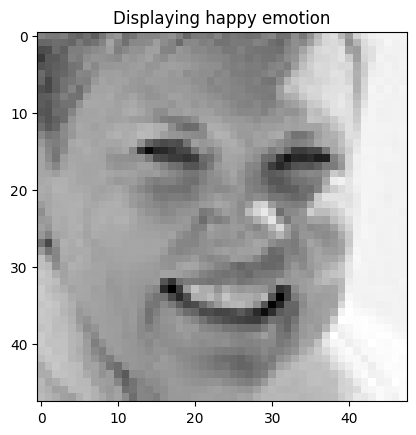

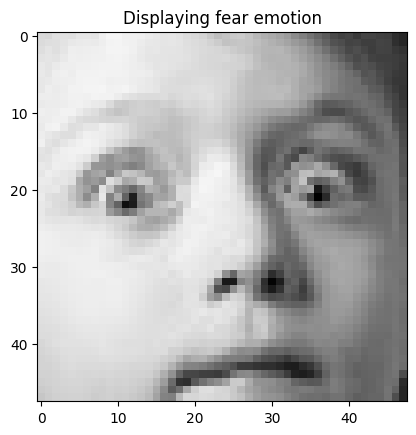

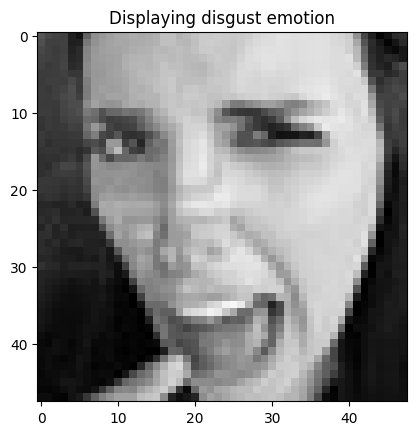

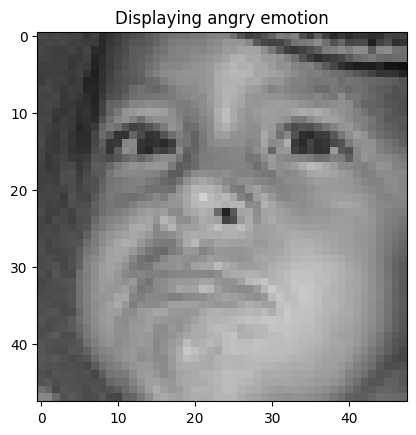

In [8]:
import glob
dataset_path = "/content/drive/MyDrive/DeepFER_dataset/"
emotions = []
for file_name in glob.glob(dataset_path+'/train/*/*'):
    emotion = file_name.split('/')[-2]
    if emotion not in emotions:
        img = cv2.imread(file_name)
        plt.imshow(img)
        plt.title("Displaying {} emotion".format(emotion))
        plt.show()
    emotions.append(emotion)

In [9]:
# specifing new image shape for resnet
img_shape = 224
batch_size = 64

## **ImageDataGenerators for ResNet50V2**

In [10]:
train_preprocessor = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,              # better for face angles
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    brightness_range=[0.7, 1.3],    # important for FER
    horizontal_flip=True,
    fill_mode='nearest',
)

test_preprocessor = ImageDataGenerator(
    rescale=1/255.,
)


## **Data Loaders**

In [11]:
train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


✔ Why this step is required

1. Face emotions change with lighting, head angle, zoom level, etc.

2. Data augmentation simulates real-world variations → prevents overfitting.

3. rescale=1/255 normalizes pixel values → faster + more stable training.

4. Using augmentations only on training and NOT on test data ensures fair evaluation.

## **Build ResNet50V2 Base Model**

In [12]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

num_classes = train_data.num_classes

base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_shape, img_shape, 3)
)

base_model.trainable = False  # Freeze entire base

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


ResNet50V2 already learned powerful visual features from millions of images.

Freezing layers prevents destroying those learned features.

Saves training time and prevents overfitting.

In [13]:
# Freezing all layers except last 50
base_model.trainable = True   # allow some layers to be trainable

for layer in base_model.layers[:-50]:
    layer.trainable = False


## **Adding Custom Final Output Layers in ResNet50V2 Model**

In [14]:
# Load the base ResNet50V2 model (without the top classifier)
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(img_shape, img_shape, 3)
)

# Freeze all layers initially
base_model.trainable = False
print("Base ResNet50V2 model loaded and frozen.")

Base ResNet50V2 model loaded and frozen.


The original ResNet50V2 was trained for ImageNet (1000 classes).
Your FER dataset has 7 emotion classes, so you must add a new classifier head.

| Layer                  | Why it is needed                                           |
| ---------------------- | ---------------------------------------------------------- |
| `Flatten()`            | Converts feature maps into a 1D vector for Dense layers    |
| `Dense(64, relu)`      | Learns task-specific emotional features                    |
| `BatchNormalization()` | Stabilizes training & reduces sensitivity to learning rate |
| `Dropout`              | Prevents overfitting                                       |
| `Dense(7, softmax)`    | Outputs 7 emotion class probabilities                      |


In [15]:
# Get output from base model
x = base_model.output

# Global Average Pooling (reduces feature maps)
x = GlobalAveragePooling2D()(x)

# Regularization to prevent overfitting
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Fully Connected Layer
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Final Output Layer
outputs = Dense(num_classes, activation='softmax')(x)

# Final ResNet50V2 model
model = Model(inputs=base_model.input, outputs=outputs)

## **Compile the model**

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,100,359 (91.94 MB)

 Trainable params: 530,951 (2.03 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

In [17]:
#Import Callback Libaries
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Model Checkpoint (Save Best Model)
checkpoint_path = "ResNet50V2_Best_Model.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    mode='max',
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning rate on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
 # Combine All Callbacks
callbacks = [checkpoint_callback, early_stop, reduce_lr]

# Steps per Epoch Setup
steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size


✔ Why they are required

1️⃣ EarlyStopping

Stops training when validation accuracy stops improving.

Prevents overfitting and saves training time.

2️⃣ ReduceLROnPlateau

If validation loss is not improving → reduce learning rate.

Helps model escape plateaus and find a better minimum.

3️⃣ ModelCheckpoint

Saves the best model only, not the last one.

Prevents losing best weights in later bad epochs.

## **Training the ResNet50V2 Model**

In [18]:
# --------------------------------------------
#  TRAINING THE RESNET50V2 MODEL
# --------------------------------------------
ResNet50V2_history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.3044 - loss: 2.1944 
Epoch 1: val_accuracy improved from -inf to 0.46605, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 12428s 28s/step - accuracy: 0.3044 - loss: 2.1937 - val_accuracy: 0.4661 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 2/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.4531 - loss: 1.4594

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.46605 to 0.46690, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.4531 - loss: 1.4594 - val_accuracy: 0.4669 - val_loss: 1.4161 - learning_rate: 0.0010
Epoch 3/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3986 - loss: 1.5745
Epoch 3: val_accuracy improved from 0.46690 to 0.49034, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.3986 - loss: 1.5745 - val_accuracy: 0.4903 - val_loss: 1.3519 - learning_rate: 0.0010
Epoch 4/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 53s 120ms/step - accuracy: 0.4219 - loss: 1.5066
Epoch 4: val_accuracy improved from 0.49034 to 0.49119, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.4219 - loss: 1.5066 - val_accuracy: 0.4912 - val_loss: 1.3520 - learning_rate: 0.0010
Epoch 5/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4219 - loss: 1.5032
Epoch 5: val_accuracy improved from 0.49119 to 0.49744, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.4219 - loss: 1.5032 - val_accuracy: 0.4974 - val_loss: 1.3332 - learning_rate: 0.0010
Epoch 6/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.3438 - loss: 1.5658
Epoch 6: val_accuracy improved from 0.49744 to 0.49830, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.3438 - loss: 1.5658 - val_accuracy: 0.4983 - val_loss: 1.3337 - learning_rate: 0.0010
Epoch 7/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4262 - loss: 1.4901
Epoch 7: val_accuracy did not improve from 0.49830
450/450 ━━━━━━━━━━━━━━━━━━━━ 512s 1s/step - accuracy: 0.4262 - loss: 1.4901 - val_accuracy: 0.4928 - val_loss: 1.3278 - learning_rate: 0.0010
Epoch 8/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 54s 121ms/step - accuracy: 0.3906 - loss: 1.5222
Epoch 8: val_accuracy did not improve from 0.49830
450/450 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.3906 - loss: 1.5222 - val_accuracy: 0.4928 - val_loss: 1.3287 - learning_rate: 0.0010
Epoch 9/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4366 - loss: 1.4660
Epoch 9: val_accuracy improved from 0.49830 to 0.50284, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - accuracy: 0.4366 - loss: 1.4660 - val_accuracy: 0.5028 - val_loss: 1.3102 - learning_rate: 0.0010
Epoch 10/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 58s 129ms/step - accuracy: 0.3750 - loss: 1.5865
Epoch 10: val_accuracy improved from 0.50284 to 0.50327, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.3750 - loss: 1.5865 - val_accuracy: 0.5033 - val_loss: 1.3110 - learning_rate: 0.0010
Epoch 11/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4321 - loss: 1.4696
Epoch 11: val_accuracy improved from 0.50327 to 0.50526, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.4321 - loss: 1.4696 - val_accuracy: 0.5053 - val_loss: 1.3028 - learning_rate: 0.0010
Epoch 12/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 58s 130ms/step - accuracy: 0.4062 - loss: 1.5552
Epoch 12: val_accuracy improved from 0.50526 to 0.50653, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.4062 - loss: 1.5552 - val_accuracy: 0.5065 - val_loss: 1.3028 - learning_rate: 0.0010
Epoch 13/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4421 - loss: 1.4436
Epoch 13: val_accuracy improved from 0.50653 to 0.51293, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.4421 - loss: 1.4436 - val_accuracy: 0.5129 - val_loss: 1.2880 - learning_rate: 0.0010
Epoch 14/15
  1/450 ━━━━━━━━━━━━━━━━━━━━ 54s 122ms/step - accuracy: 0.3594 - loss: 1.4479
Epoch 14: val_accuracy improved from 0.51293 to 0.51435, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3594 - loss: 1.4479 - val_accuracy: 0.5143 - val_loss: 1.2877 - learning_rate: 0.0010
Epoch 15/15
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4376 - loss: 1.4565
Epoch 15: val_accuracy improved from 0.51435 to 0.51790, saving model to ResNet50V2_Best_Model.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.4376 - loss: 1.4565 - val_accuracy: 0.5179 - val_loss: 1.2816 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.


Model updates weights by learning patterns from training images.

Validation data monitors whether the model is generalizing.

## **Evaluate ResNet50V2 Model**

In [22]:
from keras.models import load_model

ResNet50V2_Model = load_model("ResNet50V2_Best_Model.h5")

In [23]:
# --------------------------------------------
# 📌 MODEL EVALUATION ON TEST DATA
# --------------------------------------------
ResNet50V2_score = ResNet50V2_Model.evaluate(test_data)

print(f"Test Loss     : {ResNet50V2_score[0]:.5f}")
print(f"Test Accuracy : {ResNet50V2_score[1] * 100:.2f}%")


111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.4156 - loss: 1.4365
Test Loss     : 1.28109
Test Accuracy : 51.84%


Gives final performance on unseen test images.

Helps determine whether your model is ready for deployment.

In [24]:
# --------------------------------------------
# 📌 PLOT TRAINING & VALIDATION CURVES
# --------------------------------------------
import matplotlib.pyplot as plt

def plot_curves(history):

    acc      = history.history['accuracy']
    val_acc  = history.history['val_accuracy']
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


This Shows trends of training/validation accuracy and loss.

Helps detect:

overfitting

underfitting

learning rate issues

whether more training is required

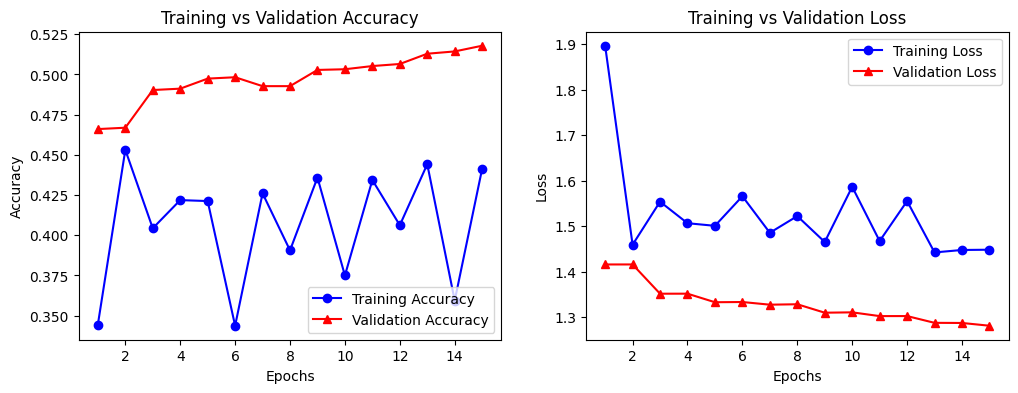

In [25]:
# Plot The Curve
plot_curves(ResNet50V2_history)

## **Generate Predictions Correctly**

In [26]:
# --------------------------------------------
# 📌 PREDICTIONS
# --------------------------------------------
pred_probs = ResNet50V2_Best_Model.h5.predict(test_data)
ResNet50V2_Predictions = np.argmax(pred_probs, axis=1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 295ms/step


## **Confusion Matrix**

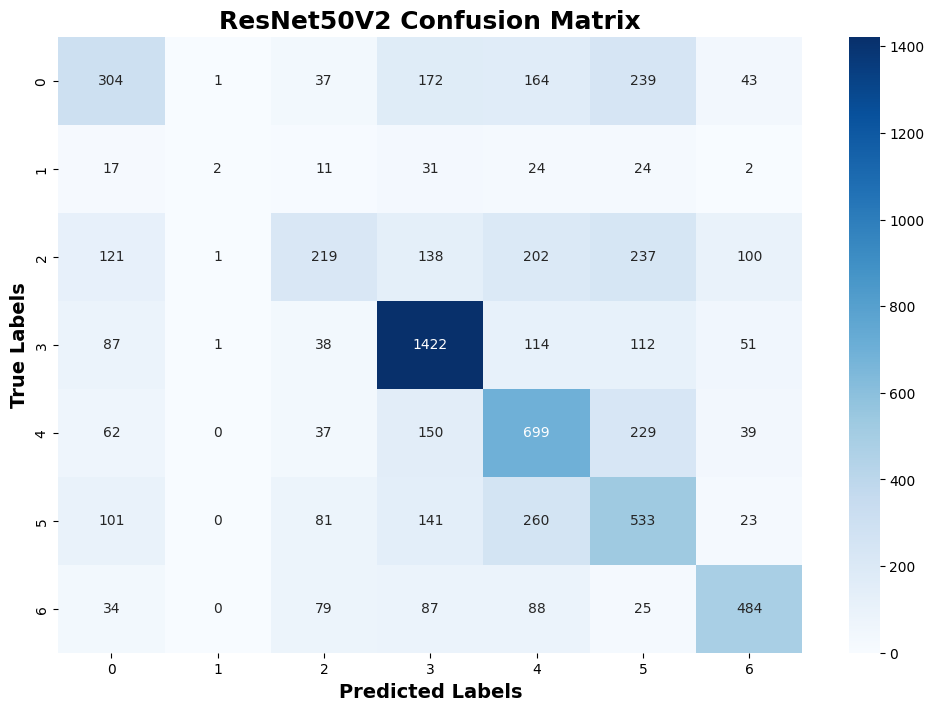

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_data.labels, ResNet50V2_Predictions)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.xlabel("Predicted Labels", fontsize=14, fontweight='bold')
plt.ylabel("True Labels", fontsize=14, fontweight='bold')
plt.title("ResNet50V2 Confusion Matrix", fontsize=18, fontweight='bold')
plt.show()


A confusion matrix helps you understand class-wise performance:

Which emotions are misclassified?

Is the model confusing fear vs surprise?

Are minority classes underperforming?

It gives a much deeper understanding than accuracy alone.

## **Class-wise Accuracy**

In [28]:
import pandas as pd

classes = list(test_data.class_indices.keys())

cm_df = pd.DataFrame(cm, index=classes, columns=classes)
display(cm_df)


,angry,disgust,fear,happy,neutral,sad,surprise
angry,304,1,37,172,164,239,43
disgust,17,2,11,31,24,24,2
fear,121,1,219,138,202,237,100
happy,87,1,38,1422,114,112,51
neutral,62,0,37,150,699,229,39
sad,101,0,81,141,260,533,23
surprise,34,0,79,87,88,25,484


## **Final Summary**

| Step                           | Purpose                                        |
| ------------------------------ | ---------------------------------------------- |
| Data Augmentation              | Prevents overfitting & improves generalization |
| Transfer Learning (ResNet50V2) | Uses powerful pre-learned features             |
| Freeze Layers                  | Keeps useful ImageNet knowledge                |
| Custom Head                    | Adapts model for 7-class emotion detection     |
| Callbacks                      | Makes training stable and efficient            |
| Model Training                 | Learns on your FER dataset                     |
| Evaluation                     | Measures performance on unseen data            |
| Plot Curves                    | Helps diagnose overfitting/underfitting        |
| Confusion Matrix               | Checks class-wise model behavior               |


## **Testing With Random Validation Data**

### Emotion Class Names

In [29]:
Emotion_Classes = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

### Creating Test Data Generator

In [38]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7066 images belonging to 7 classes.


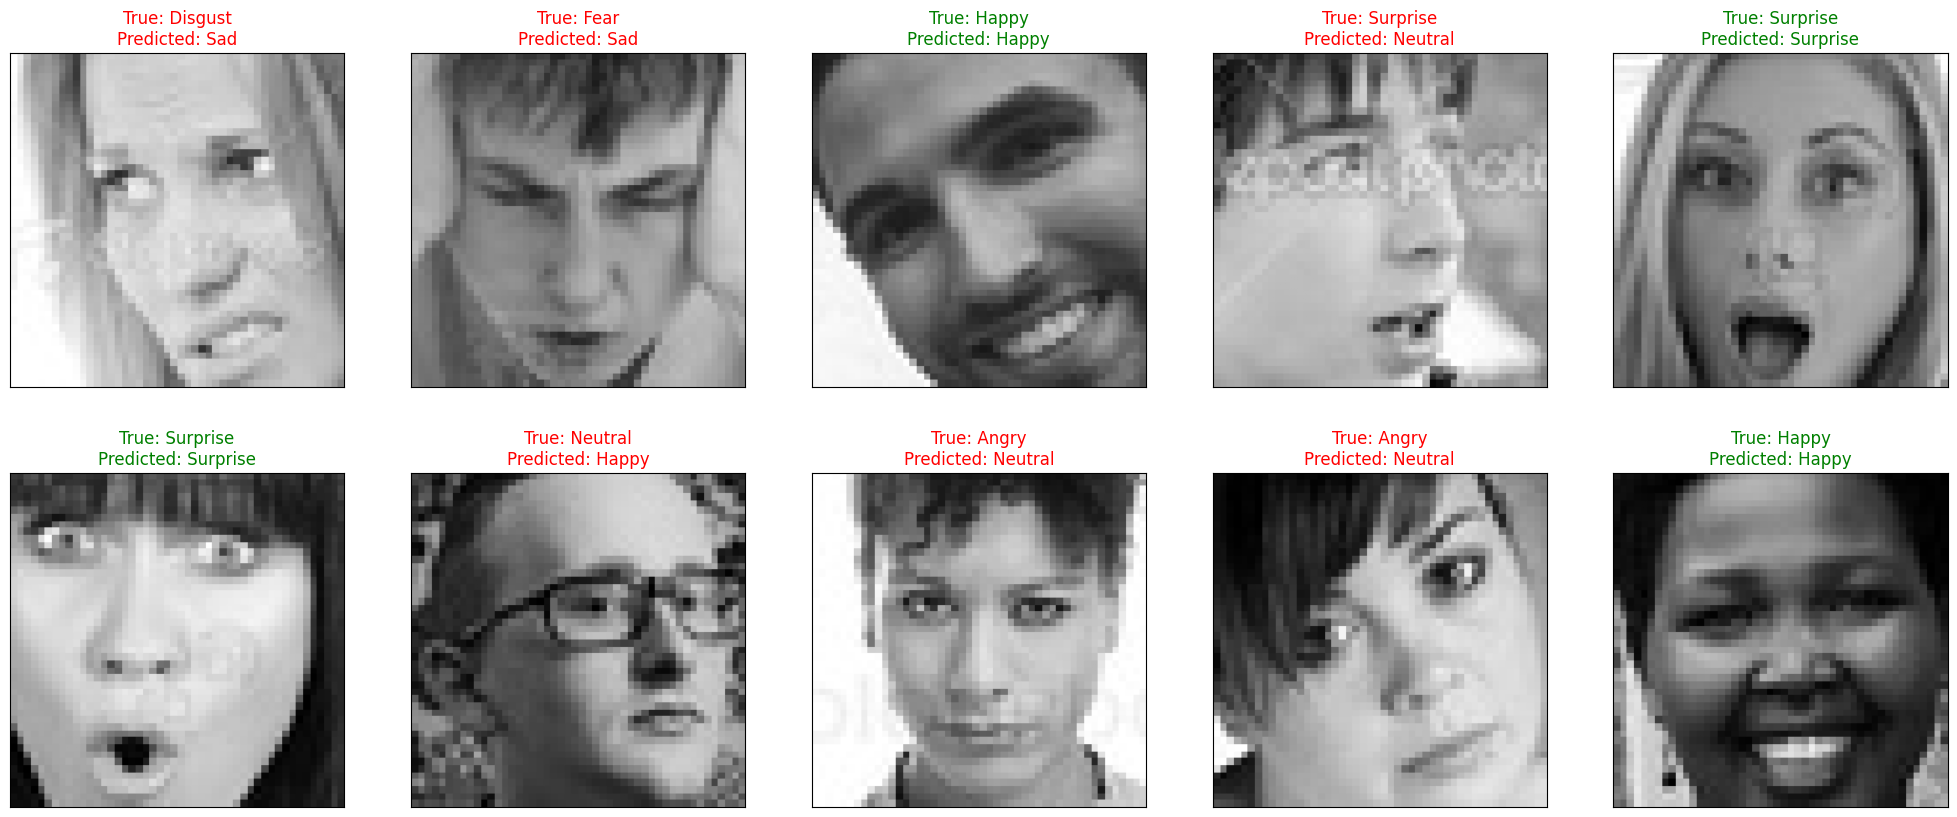

<Figure size 640x480 with 0 Axes>

In [39]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


In [37]:
model.save("ResNet50V2_Model.h5")